# Assignment 1 -Luise Kutzner, Lara Ruschmeyer, Eva Franck

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import joblib
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor


warnings.filterwarnings('ignore', module='sklearn')
pd.set_option('display.max_rows', 20)


In [9]:
def plot_y_yhat(y_test: pd.DataFrame, y_pred: pd.DataFrame, plot_title="plot"):
    labels = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3'] #y_test.columns.tolist()  # Get column names as labels
    MAX = 500
    if len(y_test) > MAX:
        idx = np.random.choice(len(y_test), MAX, replace=False)
    else:
        idx = np.arange(len(y_test))

    # Calculate mean RMSE
    #RMSE = np.sqrt(np.mean((y_test.values - y_pred.values) ** 2))
    mean_RMSE = np.mean(np.sqrt(np.mean((y_test.values - y_pred.values) ** 2, axis=0)))

    # Create the figure with subplots
    plt.figure(figsize=(12, 12))
    plt.suptitle(f'{plot_title} (Mean RMSE: {mean_RMSE:.4f})', fontsize=16, weight='bold')

    for i, col in enumerate(labels):
        # Extract the test and predicted values for the current column
        y_test_col = y_test.iloc[idx, i]
        y_pred_col = y_pred.iloc[idx, i]

        # Determine min and max for the current column
        x0 = np.min(y_test_col)
        x1 = np.max(y_test_col)
        
        # Create subplot
        plt.subplot(3, 2, i + 1)
        plt.scatter(y_test_col, y_pred_col, edgecolors='b', facecolors='none')
        plt.xlabel(f'True {col}', fontsize=12)
        plt.ylabel(f'Predicted {col}', fontsize=12)
        plt.plot([x0, x1], [x0, x1], color='red', linestyle='--', linewidth=2)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.axis('square')
        # fix x and y axis
        plt.xlim(-5, 5)
        plt.ylim(-5, 5)
        
        # Calculate and display RMSE for each variable
        rmse_individual = np.sqrt(np.mean((y_test_col - y_pred_col) ** 2))
        plt.title(f'{col}: RMSE = {rmse_individual:.4f}', fontsize=10)

    # Adjust layout for clarity
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save the plot
    plt.savefig(f'images/{plot_title}.png')

    # Show the plot
    plt.show()


def create_submission(model, submission_name, x_test_real, x_columns_train, y_columns_train, x_columns_submissions):
    for col in x_columns_train:
        if col not in x_test_real.columns:
            x_test_real[col] = 0

    y_test_real_pred = model.predict(x_test_real[x_columns_train])

    # create dataframe
    y_test_real_pred = pd.DataFrame(y_test_real_pred, columns=y_columns_train)
    # add ID column
    y_test_real_pred = y_test_real_pred[x_columns_submissions]
    y_test_real_pred['Id'] = np.arange(0, len(y_test_real_pred))
    submission_columns = ["Id","x_1","y_1","x_2","y_2","x_3","y_3"]
    y_test_real_pred = y_test_real_pred[submission_columns]
    y_test_real_pred.to_csv(f"submissions/{submission_name}", index=False)
    return y_test_real_pred

# Task 1

In [11]:
x_test_real = pd.read_csv("../mlNOVA/X_test.csv")
x_train = pd.read_csv("../mlNOVA/X_train.csv")

x_test_real.reset_index(drop=True, inplace=True)
x_train.reset_index(drop=True, inplace=True)

x_test_real["TRAJECTORY ID"] = 0
x_train["TRAJECTORY ID"] = 0

for i in range(0, len(x_test_real), 257):
    x_test_real.loc[i, "TRAJECTORY ID"] = 1
for i in range(0, len(x_train), 257):
    x_train.loc[i, "TRAJECTORY ID"] = 1

x_test_real["TRAJECTORY ID"] = x_test_real["TRAJECTORY ID"].astype(int).cumsum()
x_train["TRAJECTORY ID"] = x_train["TRAJECTORY ID"].astype(int).cumsum()

x_train["t"] = np.maximum(0.0, x_train["t"])
x_test_real["t"] = np.maximum(0.0, x_test_real["t"])

# rename columns of x_test_real x0_1,y0_1,x0_2,y0_2,x0_3,y0_3
x_test_real.columns = x_test_real.columns.str.replace(r'0_', '_')

x_train = x_train[~((x_train["t"]==0.0) & (x_train["x_1"]==0.0) & (x_train["y_1"]==0.0) & (x_train["x_2"]==0.0) & (x_train["y_2"]==0.0) & (x_train["x_3"]==0.0) & (x_train["y_3"]==0.0))]

In [12]:
def generate_dataset_one_df(df):
    columns = df.columns.tolist()  # Convert to list once
    df_values = df.values  # Convert DataFrame to numpy array for faster access
    
    X = []
    y = []
    
    i = 0
    for j in range(i + 1, len(df_values)):
        delta_t = df_values[j][0] - df_values[i][0]  # Assuming 't' is the first column
        x_row = df_values[i][1:].tolist() + [delta_t]  # Skip 't' column in x_row
        y_row = df_values[j][1:].tolist()  # Skip 't' column in y_row
        
        X.append(x_row)
        y.append(y_row)
    
    # Create DataFrames at the end
    columns_x = columns[1:] + ['t']  # Exclude 't' and add 'delta_t'
    X = pd.DataFrame(X, columns=columns_x)
    y = pd.DataFrame(y, columns=columns[1:])  # Exclude 't'

    return X, y

def generate_dataset(df):
    # for each TRAJECTORY ID create a dataset and concat them
    X = []
    y = []
    sets = df['TRAJECTORY ID'].unique()
    for s in sets:
        X_s, y_s = generate_dataset_one_df(df[df['TRAJECTORY ID'] == s])
        # add information about TRAJECTORY ID to the dataset
        X_s['TRAJECTORY ID'] = s
        y_s['TRAJECTORY ID'] = s
        X.append(X_s)
        y.append(y_s)

    X = pd.concat(X)
    y = pd.concat(y)


    return X, y

In [13]:
X_data, y_data = generate_dataset(x_train)

print(X_data.shape)

X_data.head()

/var/folders/xk/r3lwq_315xq3y9710k7djrth0000gn/T/ipykernel_1011/1376866212.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X = pd.concat(X)


(1084792, 15)


/var/folders/xk/r3lwq_315xq3y9710k7djrth0000gn/T/ipykernel_1011/1376866212.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  y = pd.concat(y)


,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id,TRAJECTORY ID,t
0,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0.0,1,0.039062
1,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0.0,1,0.078125
2,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0.0,1,0.117188
3,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0.0,1,0.156250
4,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0.0,1,0.195312


In [14]:
# find the indices where a new trajectory starts
idx = np.hstack((0, x_train[x_train.t == 10].index.values + 1))[:-1]

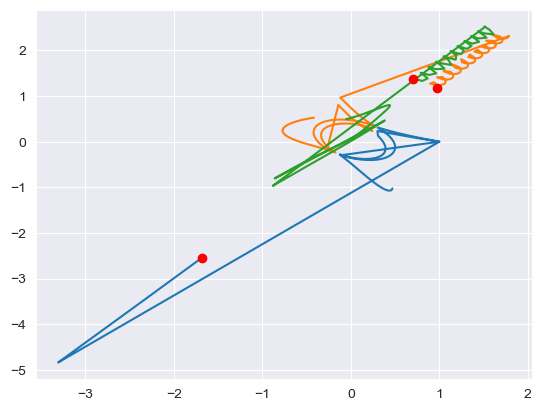

In [15]:
# plot a random trajectory 
x_train.reset_index(drop=True, inplace=True)
k = np.random.randint(idx.shape[0])
pltidx = range(idx[k], 257 + idx[k])
pltsquare = idx[k]

plt.plot(x_train.x_1[pltidx], x_train.y_1[pltidx])
plt.plot(x_train.x_2[pltidx], x_train.y_2[pltidx])
plt.plot(x_train.x_3[pltidx], x_train.y_3[pltidx])

plt.plot(x_train.x_1[pltsquare], x_train.y_1[pltsquare], 'ro')
plt.plot(x_train.x_2[pltsquare], x_train.y_2[pltsquare], 'ro')
plt.plot(x_train.x_3[pltsquare], x_train.y_3[pltsquare], 'ro')

In [19]:
# drop Id column as it is unnecessary for the model
data_cleaned = X_data.drop(columns=['Id'])
#'v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3', 

In [20]:
x_columns_train = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3','v_x_1','v_y_1','v_x_2','v_y_2','v_x_3','v_y_3','t']
y_columns_train = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3','v_x_1','v_y_1','v_x_2','v_y_2','v_x_3','v_y_3']
x_columns_submissions = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
def create_train_val_test_splits(X_data, y_data, x_columns_train, y_columns_train, random_state=42):
    x_columns = X_data.columns.tolist()
    y_columns = y_data.columns.tolist()


    # Get the unique TRAJECTORY IDs (trajectories)
    set_ids = X_data['TRAJECTORY ID'].unique()

    # Split the TRAJECTORY IDs into train+val and test (e.g., 90% train+val, 10% test)
    set_ids_train_val, set_ids_test = train_test_split(set_ids, test_size=0.1, random_state=random_state)

    # Now split the train+val TRAJECTORY IDs into train and validation sets (e.g., 75% train, 25% val)
    set_ids_train, set_ids_val = train_test_split(set_ids_train_val, test_size=0.25, random_state=random_state)
    # This gives 60% train, 20% validation, and 20% test

    # Now, select the rows from X_data and y_data based on the TRAJECTORY IDs
    X_train = X_data[X_data['TRAJECTORY ID'].isin(set_ids_train)].reset_index(drop=True)
    X_val = X_data[X_data['TRAJECTORY ID'].isin(set_ids_val)].reset_index(drop=True)
    X_test = X_data[X_data['TRAJECTORY ID'].isin(set_ids_test)].reset_index(drop=True)

    y_train = y_data[y_data['TRAJECTORY ID'].isin(set_ids_train)].reset_index(drop=True)
    y_val= y_data[y_data['TRAJECTORY ID'].isin(set_ids_val)].reset_index(drop=True)
    y_test= y_data[y_data['TRAJECTORY ID'].isin(set_ids_test)].reset_index(drop=True)

    X_train = X_train[x_columns_train]
    X_val = X_val[x_columns_train]
    X_test = X_test[x_columns_train]

    y_train = y_train[y_columns_train]
    y_val = y_val[y_columns_train]
    y_test = y_test[y_columns_train]
    
    return X_train, X_val, X_test, y_train, y_val, y_test


In [21]:
X_train, X_val, X_test, y_train, y_val, y_test = create_train_val_test_splits(X_data, y_data, x_columns_train, y_columns_train)

## Task 1.1

In [22]:
def train_model(model, X_train, y_train, X_val, y_val, X_test, y_test, x_columns_train, y_columns_train):

    results = {}

    model.fit(X_train[x_columns_train], y_train[y_columns_train])
    y_train_pred = model.predict(X_train[x_columns_train])
    y_val_pred = model.predict(X_val[x_columns_train])
    y_test_pred = model.predict(X_test[x_columns_train])

    # create dataframes
    y_train_pred = pd.DataFrame(y_train_pred, columns=y_columns_train)
    y_val_pred = pd.DataFrame(y_val_pred, columns=y_columns_train)
    y_test_pred = pd.DataFrame(y_test_pred, columns=y_columns_train)

    # caluclate the RMSE only for the columns that are in y_columns_train
    train_rmse = np.sqrt(mean_squared_error(y_train[y_columns_train], y_train_pred[y_columns_train]))
    val_rmse = np.sqrt(mean_squared_error(y_val[y_columns_train], y_val_pred[y_columns_train]))
    test_rmse = np.sqrt(mean_squared_error(y_test[y_columns_train], y_test_pred[y_columns_train]))
    results["train_rmse"] = train_rmse
    results["val_rmse"] = val_rmse
    results["test_rmse"] = test_rmse

 
    return y_train_pred, y_val_pred, y_test_pred, model, results


## Task 1.2

In [23]:
from sklearn.linear_model import LinearRegression

baseline_model = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('regressor', LinearRegression())  
])

y_train_pred_baseline, y_val_pred_baseline, y_test_pred_baseline, baseline_model, results_baseline = train_model(baseline_model, X_data, y_data,  X_val, y_val, X_test, y_test, x_columns_train, y_columns_train)
baseline_model['regressor'].score(X_train, y_train)


-1.902299640940248e+21

In [24]:
create_submission(baseline_model, "baseline_model.csv", x_test_real, x_columns_train, y_columns_train, x_columns_submissions)

,Id,x_1,y_1,x_2,y_2,x_3,y_3
0,0,0.497515,-0.255464,-0.206066,0.297315,-0.290938,-0.042014
1,1,0.490210,-0.256116,-0.205058,0.294019,-0.284637,-0.038067
2,2,0.482905,-0.256767,-0.204050,0.290723,-0.278337,-0.034119
3,3,0.475601,-0.257419,-0.203042,0.287428,-0.272037,-0.030172
4,4,0.468296,-0.258070,-0.202034,0.284132,-0.265737,-0.026224
...,...,...,...,...,...,...,...
1041616,1041616,-1.587504,-0.548327,0.038634,-0.581305,1.550177,1.129486
1041617,1041617,-1.594808,-0.548979,0.039642,-0.584600,1.556477,1.133434
1041618,1041618,-1.602114,-0.549630,0.040650,-0.587897,1.562778,1.137382
1041619,1041619,-1.609418,-0.550282,0.041658,-0.591192,1.569078,1.141329


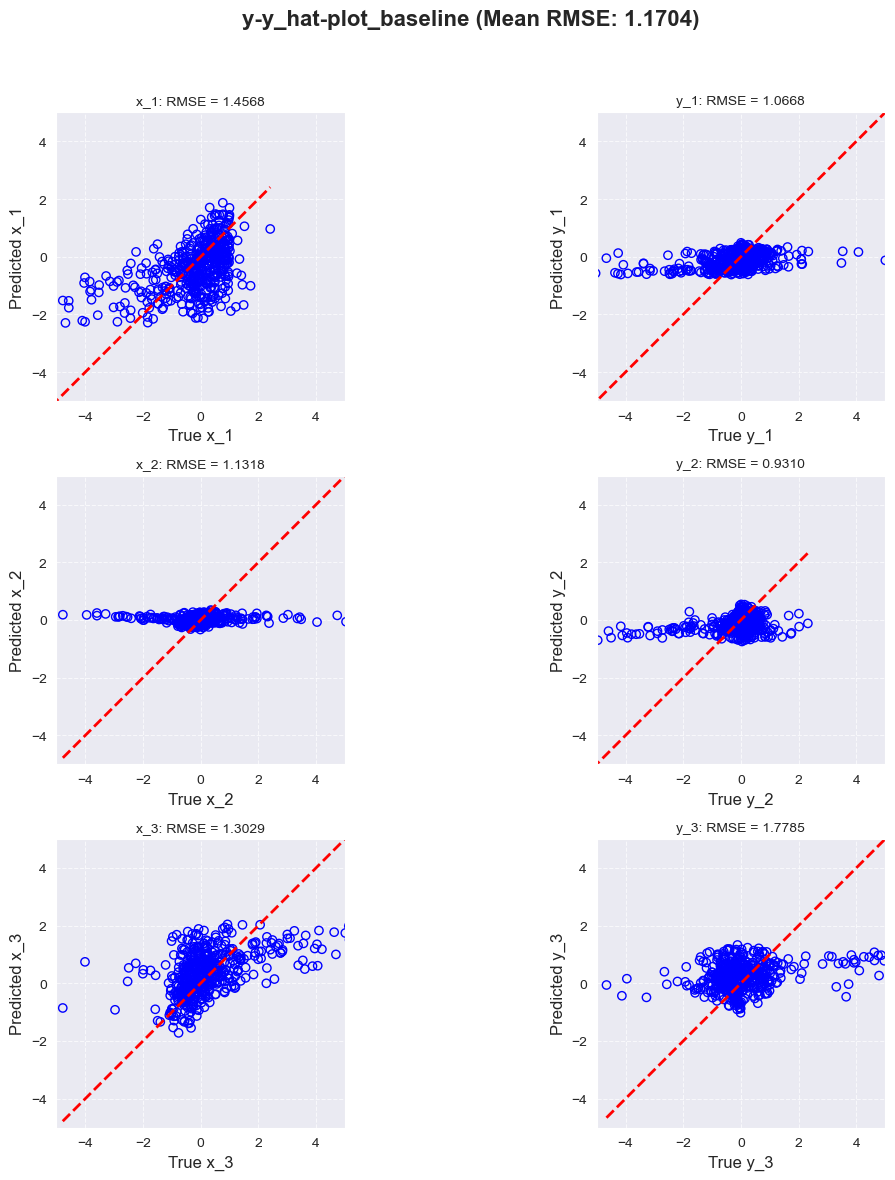

In [25]:
plot_y_yhat(y_val,y_val_pred_baseline,"y-y_hat-plot_baseline")

## Task 2

In [26]:
X_train

,x_1,y_1,x_2,y_2,x_3,y_3,v_x_1,v_y_1,v_x_2,v_y_2,v_x_3,v_y_3,t
0,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196,0.0,0.0,0.0,0.0,0.0,0.0,0.039062
1,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196,0.0,0.0,0.0,0.0,0.0,0.0,0.078125
2,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196,0.0,0.0,0.0,0.0,0.0,0.0,0.117188
3,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196,0.0,0.0,0.0,0.0,0.0,0.0,0.156250
4,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196,0.0,0.0,0.0,0.0,0.0,0.0,0.195312
...,...,...,...,...,...,...,...,...,...,...,...,...,...
733381,1.0,0.0,-0.300429,0.400142,-0.699571,-0.400142,0.0,0.0,0.0,0.0,0.0,0.0,9.843750
733382,1.0,0.0,-0.300429,0.400142,-0.699571,-0.400142,0.0,0.0,0.0,0.0,0.0,0.0,9.882810
733383,1.0,0.0,-0.300429,0.400142,-0.699571,-0.400142,0.0,0.0,0.0,0.0,0.0,0.0,9.921880
733384,1.0,0.0,-0.300429,0.400142,-0.699571,-0.400142,0.0,0.0,0.0,0.0,0.0,0.0,9.960940


In [27]:
def sample_trajectories(X, y, size=200):
    X_sampled = X.sample(size, random_state=42)
    y_sampled = y.loc[X_sampled.index]
    return X_sampled, y_sampled
    
size = int(len(X_train)*0.01)

X_train_sampled, y_train_sampled = sample_trajectories(X_train, y_train, size)
X_val_sampled, y_val_sampled = sample_trajectories(X_val, y_val, size)
X_test_sampled, y_test_sampled = sample_trajectories(X_test, y_test, size)

In [28]:
# perform polynomial regression with different polynomial degrees and different regressors
def validate_poly_regression(X_train, y_train, X_val, y_val, regressor=None, degrees=range(1,15), max_features=None):
    
    if regressor is None:
        regressor = LinearRegression()
    elif regressor == 'MultiTaskLassoCV':
        regressor = MultiTaskLassoCV(alphas=np.logspace(-6, 6, 10), cv = 5)
    elif regressor == 'RidgeCV':
        regressor = RidgeCV(alphas=np.logspace(-6, 6, 10), store_cv_values=True)
    else:
        raise ValueError("Invalid regressor type.")
    
    best_rmse = float('inf')
    rmse_dict = {}
    best_pipeline = None

    
    # iterate through the polynomial degrees
    for degree in degrees:
        # pipeline for polynomial regression
        pipeline = Pipeline(steps=[
                ('poly', PolynomialFeatures(degree=degree)),
                ('scaler', StandardScaler()),
                ('regressor', regressor)
            ])
        
        pipeline.fit(X_train, y_train)
        
        # number of features for each degree
        poly_features = pipeline.named_steps['poly']
        print(f'Degree: {degree}, Number of Features: {poly_features.n_output_features_}')
        
        if max_features is not None and poly_features.n_output_features_ > max_features:
            print(f"Skipping degree {degree} as it exceeds max_features={max_features}.")
            continue
        
        y_val_pred = pipeline.predict(X_val)
        
        num_features = pipeline.named_steps['poly'].n_output_features_
        
        # drop t and velocities from the dataframes to calculate the RMSE to compare the predicted values with the true values for all degrees
        X_val_without_t = X_val.drop(columns=['t'])
        y_val_pred_df = pd.DataFrame(y_val_pred, columns=X_val_without_t.columns)
        y_val_pred_df.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
        y_val_eval = y_val.copy()
        y_val_eval.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)

        rmse = np.sqrt(mean_squared_error(y_val_eval, y_val_pred_df))
        print(f'Degree: {degree}, RMSE: {rmse}')
        
        rmse_dict[degree] = rmse
        
        # update the best degree if the current model is better
        if rmse < best_rmse:
            best_rmse = rmse
            best_pipeline = pipeline
        
        if max_features is not None and num_features > max_features:
            break
        
    return rmse_dict, best_rmse, best_pipeline
    
    

In [29]:
# run the function 10 times that validates the polynomial regression with degrees from 1 to 6 (because it loaded way too long with 15 degrees) and linear regressor
linear_pipelines_list = []
rmse_linear_list = []
for i in range(1):
    rmse_dict_linear, best_rmse_linear, best_pipeline_linear = validate_poly_regression(X_train_sampled[x_columns_train], y_train_sampled, X_val_sampled[x_columns_train], y_val_sampled, regressor=None, degrees=range(1,4), max_features=None)
    linear_pipelines_list.append(best_pipeline_linear)
    rmse_linear_list.append(best_rmse_linear)

Degree: 1, Number of Features: 14
Degree: 1, RMSE: 1.4201015212367796
Degree: 2, Number of Features: 105
Degree: 2, RMSE: 1.3787265858864188
Degree: 3, Number of Features: 560
Degree: 3, RMSE: 1.4371641118601608


In [30]:
#best degree is 2
best_degree = 2
best_alpha = 0.01

# Create polynomial features
model_2 = Pipeline(
    steps=[
        ("poly", PolynomialFeatures(degree=best_degree, include_bias=False)),
        ("scaler", StandardScaler()),
        ("regressor", Ridge(alpha=best_alpha)),
    ]
)


y_pred_train_2, y_pred_val_2, y_pred_test_2, model_2, results_2 = train_model(
    model_2,
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
    x_columns_train,
    y_columns_train,
)

In [31]:
results_2

{'train_rmse': 1.1518874143633868,
 'val_rmse': 1.1882602617299183,
 'test_rmse': 1.3150799834621378}

In [32]:
create_submission(model_2, "polynomial_submission.csv", x_test_real, x_columns_train, y_columns_train, x_columns_submissions)

,Id,x_1,y_1,x_2,y_2,x_3,y_3
0,0,0.804279,-0.028380,-0.307496,0.491417,-0.496783,-0.463037
1,1,0.791660,-0.031984,-0.306360,0.484824,-0.485300,-0.452840
2,2,0.779078,-0.035567,-0.305224,0.478247,-0.473854,-0.442681
3,3,0.766532,-0.039128,-0.304088,0.471688,-0.462444,-0.432560
4,4,0.754023,-0.042669,-0.302953,0.465147,-0.451070,-0.422478
...,...,...,...,...,...,...,...
1041616,1041616,-1.524792,-0.575015,-0.100857,-0.829707,1.625649,1.404722
1041617,1041617,-1.529785,-0.574062,-0.099487,-0.832885,1.629272,1.406946
1041618,1041618,-1.534743,-0.573087,-0.098118,-0.836046,1.632860,1.409133
1041619,1041619,-1.539663,-0.572091,-0.096749,-0.839189,1.636411,1.411280


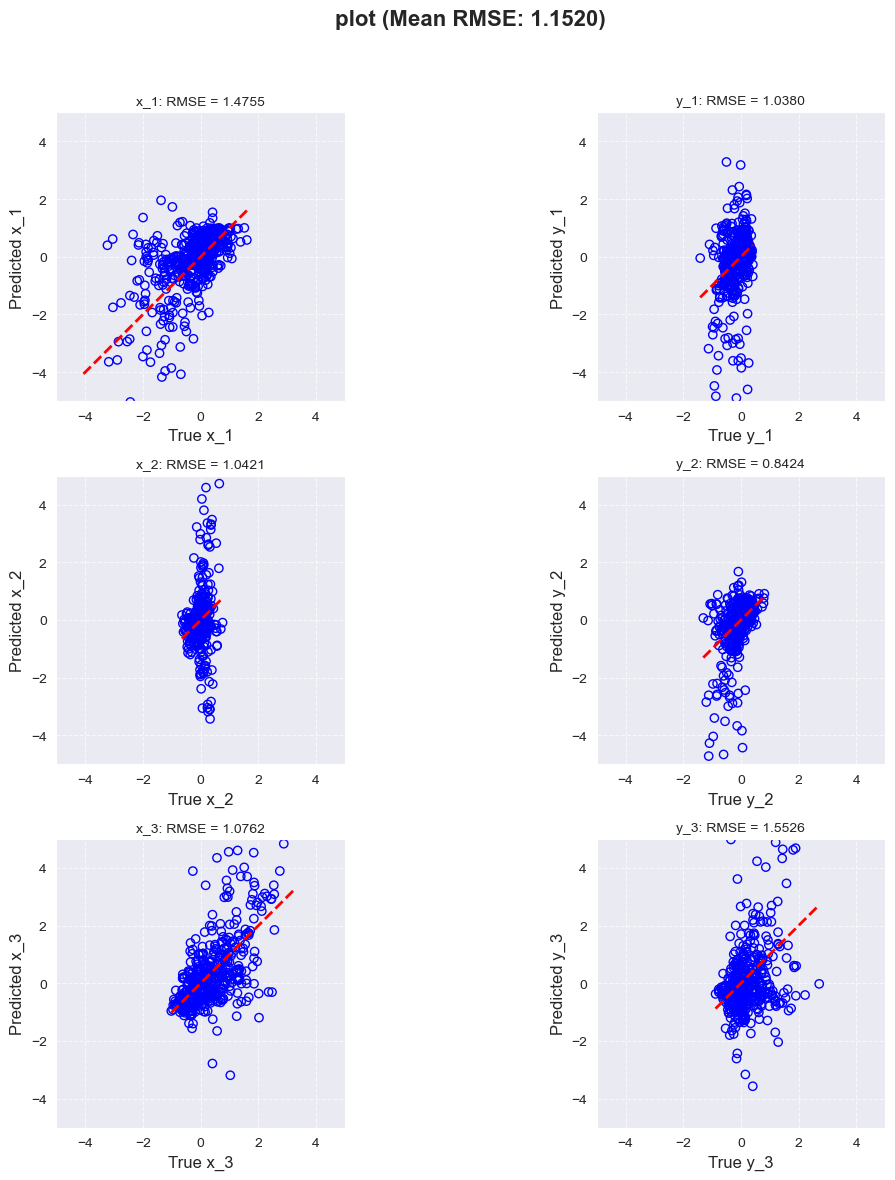

In [33]:
plot_y_yhat(y_pred_val_2, y_val)

# Task 3

## Task 3.1

In [34]:
X_train_sampled[x_columns_train]

,x_1,y_1,x_2,y_2,x_3,y_3,v_x_1,v_y_1,v_x_2,v_y_2,v_x_3,v_y_3,t
516002,1.0,0.0,-0.166678,0.418743,-0.833322,-0.418743,0.0,0.0,0.0,0.0,0.0,0.0,4.882810
512801,1.0,0.0,-0.459893,0.878443,-0.540107,-0.878443,0.0,0.0,0.0,0.0,0.0,0.0,0.742188
103267,1.0,0.0,-0.056699,0.305315,-0.943301,-0.305315,0.0,0.0,0.0,0.0,0.0,0.0,2.343750
532402,1.0,0.0,-0.380570,0.796593,-0.619430,-0.796593,0.0,0.0,0.0,0.0,0.0,0.0,8.046880
68975,1.0,0.0,-0.128560,0.396576,-0.871440,-0.396576,0.0,0.0,0.0,0.0,0.0,0.0,9.531250
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199907,1.0,0.0,-0.418773,0.661981,-0.581227,-0.661981,0.0,0.0,0.0,0.0,0.0,0.0,7.656250
269400,1.0,0.0,-0.316170,0.086247,-0.683830,-0.086247,0.0,0.0,0.0,0.0,0.0,0.0,5.039060
352788,1.0,0.0,-0.378307,0.837054,-0.621693,-0.837054,0.0,0.0,0.0,0.0,0.0,0.0,9.843750
690977,1.0,0.0,-0.318710,0.706715,-0.681290,-0.706715,0.0,0.0,0.0,0.0,0.0,0.0,0.820312


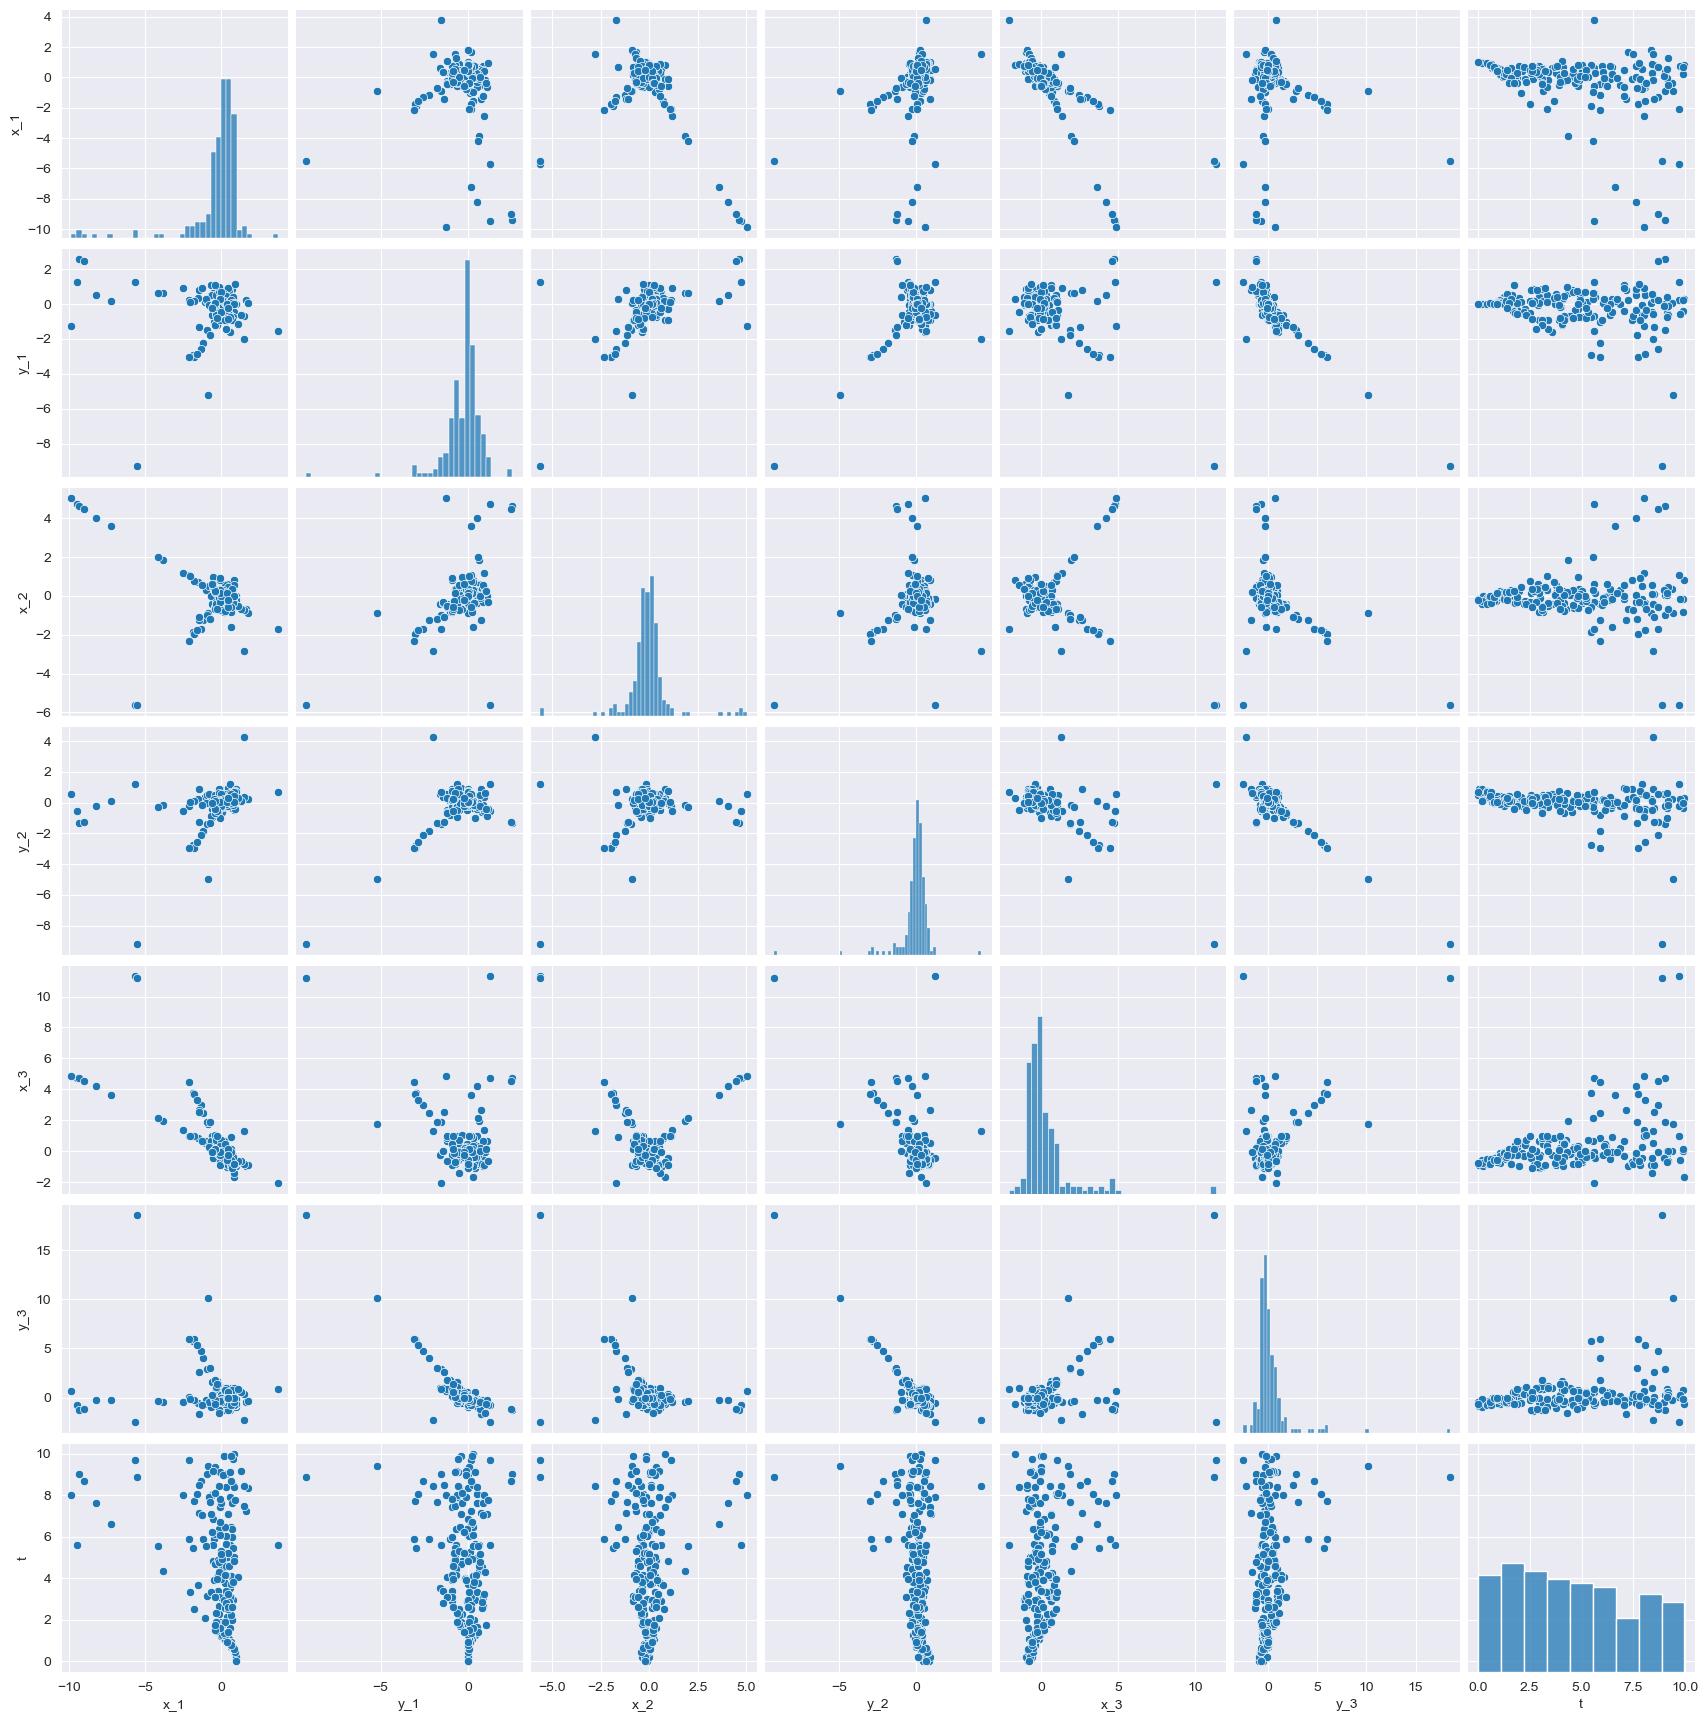

In [35]:
# drop velocities because there all 0 anyway at the start
# so there will be no correlation
X_train_without_v = x_train[x_columns_train].drop(['v_x_1','v_y_1','v_x_2','v_y_2','v_x_3','v_y_3'], axis=1)

# Sample a subset of the data
sampled_data = X_train_without_v.sample(200, random_state=42)

# Pairplot for visualizing relationships between positions and velocities
sns.pairplot(sampled_data, kind="scatter")
plt.show()

<Axes: >

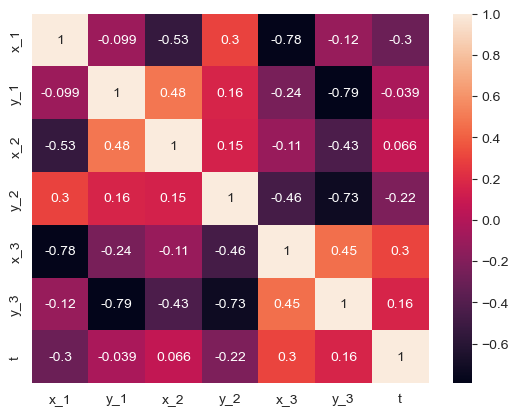

In [36]:
# check linear correlations with the heatmap
corr = X_train_without_v.corr()
#corr = y_train.corr()
sns.heatmap(corr,annot=True)

In [37]:
# sort values 
sorted_corr = corr.abs().unstack().sort_values(kind="quicksort", ascending=False)
sorted_corr = sorted_corr[sorted_corr < 1.0]  # without self correlation

In [38]:
# top 10 highest correlations
print("Top 10 of Highest Correlation:")
print(sorted_corr.head(10))

Top 10 of Highest Correlation:
y_1  y_3    0.792859
y_3  y_1    0.792859
x_3  x_1    0.780996
x_1  x_3    0.780996
y_2  y_3    0.728556
y_3  y_2    0.728556
x_2  x_1    0.534279
x_1  x_2    0.534279
x_2  y_1    0.484456
y_1  x_2    0.484456
dtype: float64


### feature elimination after splitting

In [39]:
# remove velocities from X dataframe, because they are 0 anyway

X_train_wo_v = x_train.drop(columns=['v_x_1','v_y_1','v_x_2','v_y_2','v_x_3','v_y_3'])
X_val_wo_v = X_val.drop(columns=['v_x_1','v_y_1','v_x_2','v_y_2','v_x_3','v_y_3'])

In [40]:
# changing format of dataframes for the prediction

#def format_df_for_plot(df):
#    return df[['x_1','y_1','x_2','y_2','x_3','y_3']]

# Function to remove variables and evaluate performance

def remove_variables(x, train, validation, y_train, y_val, pipeline):
    redundant_variable = x  # Variable to remove
    
    # Drop the redundant variable from the training and validation sets
    X_train_reduced = train.drop(columns=[redundant_variable])
    X_val_reduced = validation.drop(columns=[redundant_variable])
    
    y_train_reduced = y_train.copy()
    y_val_reduced = y_val.copy()

    # Fit the pipeline on the reduced training set
    pipeline.fit(X_train_reduced, y_train_reduced)
    #print(f"Training Score after removing {redundant_variable}: {pipeline['regressor'].score(X_train_reduced, y_train_reduced)}")

    # Predict on the reduced validation set
    y_val_pred_reduced = pipeline.predict(X_val_reduced)
   
    # Since the columns of y_val might not match those of X, use the columns of y_val for the prediction dataframe
    y_val_pred_2_df = pd.DataFrame(y_val_pred_reduced, columns=y_val_reduced.columns)
   
    # Calculate RMSE for the reduced model
    rmse_reduced = np.sqrt(mean_squared_error(y_val_reduced, y_val_pred_reduced))
    print(f'Root Mean Squared Error after removing {redundant_variable}: {rmse_reduced}') 

    # remove t column and id for y-y-hat-plot
    y_val_reduced_without_t = y_val_reduced.drop(['t','trajectory_id'], axis=1)
    y_val_pred_2_without_t = y_val_pred_2_df.drop(['t','trajectory_id'], axis=1)

    # Call the updated plot_y_yhat function with the predicted and true values
    plot_y_yhat(y_val_reduced_without_t.to_numpy(), y_val_pred_2_without_t.to_numpy())#, labels=y_val.columns)

    return rmse_reduced, X_train_reduced, X_val_reduced


In [41]:
pipeline = linear_pipelines_list[0]

In [44]:
# remove x3 from dataframe with velocities
rmse_x3, X_train_x3, X_val_x3 = remove_variables('x_3',X_train_wo_v,X_val_wo_v, y_train,y_val,pipeline)

ValueError: Found input variables with inconsistent numbers of samples: [1089790, 733386]

In [45]:
# remove y1
rmse_x3y1, X_train_x3y1, X_val_x3y1 = remove_variables('y_1',X_train_x3,X_val_x3, y_train,y_val, pipeline)

NameError: name 'X_train_x3' is not defined

In [102]:
# remove y2
rmse_x3y1y2, X_train_x3y1y2, X_val_x3y1y2 = remove_variables('y_2',X_train_x3y1,X_val_x3y1, y_train, y_val, pipeline)

NameError: name 'X_train_x3y1' is not defined

Removing x2, also increases the rmse, so it doesn't make sense

The final choice is to eliminate y1 and x3.

## Task 3.2

In [72]:
best_degree = 2
best_alpha = 0.01
x_columns_train_reduced = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3','v_x_1','t']
y_columns_train_reduced = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3','v_x_1']


# Create polynomial features
model_32 = Pipeline(
    steps=[
        ("poly", PolynomialFeatures(degree=best_degree, include_bias=False)),
        ("scaler", StandardScaler()),
        ("regressor", Ridge(alpha=best_alpha)),
    ]
)


y_pred_train_32, y_pred_val_32, y_pred_test_32, model_32, results_32 = train_model(
    model_32,
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
    x_columns_train,
    y_columns_train,
)

In [73]:
create_submission(model_32, "reduced_polynomial_submission.csv", x_test_real, x_columns_train, y_columns_train, x_columns_submissions)

,Id,x_1,y_1,x_2,y_2,x_3,y_3
0,0,0.804279,-0.028380,-0.307496,0.491417,-0.496783,-0.463037
1,1,0.791660,-0.031984,-0.306360,0.484824,-0.485300,-0.452840
2,2,0.779078,-0.035567,-0.305224,0.478247,-0.473854,-0.442681
3,3,0.766532,-0.039128,-0.304088,0.471688,-0.462444,-0.432560
4,4,0.754023,-0.042669,-0.302953,0.465147,-0.451070,-0.422478
...,...,...,...,...,...,...,...
1041616,1041616,-1.524792,-0.575015,-0.100857,-0.829707,1.625649,1.404722
1041617,1041617,-1.529785,-0.574062,-0.099487,-0.832885,1.629272,1.406946
1041618,1041618,-1.534743,-0.573087,-0.098118,-0.836046,1.632860,1.409133
1041619,1041619,-1.539663,-0.572091,-0.096749,-0.839189,1.636411,1.411280


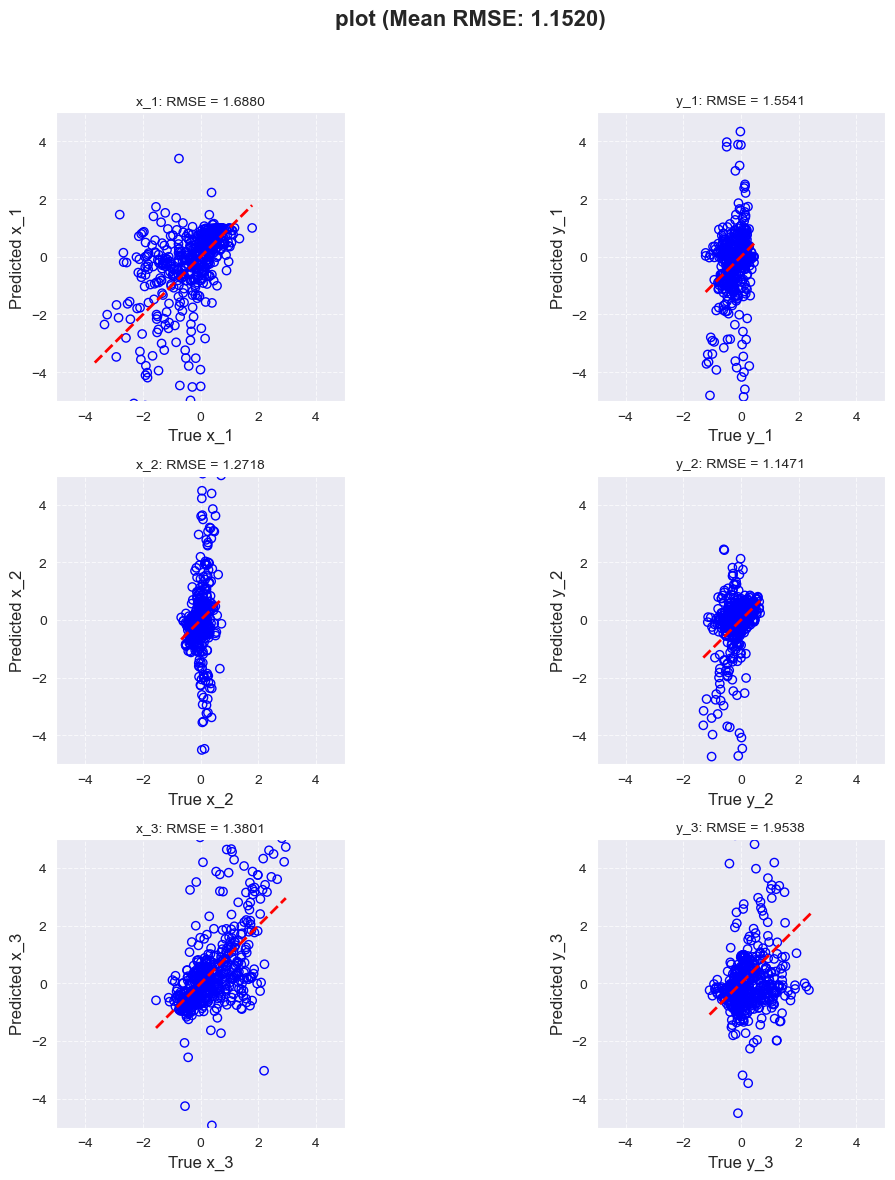

In [45]:
plot_y_yhat(y_pred_val_32, y_val)

## Task 3.3 Adding Variables

In [46]:
# define function for the features which decreased RMSE

def add_features(df1):

    df = df1.copy()

    # Compute position norms
    df['norm_1'] = np.sqrt(df['x_1']**2 + df['y_1']**2)
    df['norm_2'] = np.sqrt(df['x_2']**2 + df['y_2']**2)
    df['norm_3'] = np.sqrt(df['x_3']**2 + df['y_3']**2)

    df['squared_distance_12'] = (df['x_3'] - df['x_2'])**2 + (df['y_3'] - df['y_2'])**2

    df['area'] = 0.5 * np.abs(df['x_1'] * (df['y_2'] - df['y_3']) + 
                               df['x_2'] * (df['y_3'] - df['y_1']) + 
                               df['x_3'] * (df['y_1'] - df['y_2']))
    
    df['angle_12'] = np.arctan2(df['y_2'] - df['y_1'], df['x_2'] - df['x_1'])
    df['angle_13'] = np.arctan2(df['y_3'] - df['y_1'], df['x_3'] - df['x_1'])
    df['angle_23'] = np.arctan2(df['y_3'] - df['y_2'], df['x_3'] - df['x_2'])

    return df


In [47]:
# add feature
X_train_added = add_features(X_train)
X_val_added = add_features(X_val)

#y_val_o = y_val.drop(columns=['t','trajectory_id'])

# perform pipeline

pipeline.fit(X_train_added, y_train)
#pipeline['regressor'].score(X_train_added, y_train)

# Prediction with added feature
y_val_pred_added = pipeline.predict(X_val_added)
y_val_pred_added_df = pd.DataFrame(y_val_pred_added, columns=y_val.columns)
#y_val_pred_added_df = y_val_pred_added_df.drop(columns=['t','trajectory_id'])

# Calculate RMSE
rmse = mean_squared_error(y_val, y_val_pred_added_df)
rmse_norm = np.sqrt(mean_squared_error(y_val, y_val_pred_added_df))

print(f"Baseline RMSE: {rmse}")
print(f"Norm RMSE: {rmse_norm}")

Baseline RMSE: 1.2278548583824065
Norm RMSE: 1.1080861240817008


In [53]:
# add relative distances

def relative_distance(df1):
    df = df1.copy()
    df['distance_12'] = np.sqrt((df['x_2'] - df['x_1'])**2 + (df['y_2'] - df['y_1'])**2)
    df['distance_13'] = np.sqrt((df['x_3'] - df['x_1'])**2 + (df['y_3'] - df['y_1'])**2)
    df['distance_23'] = np.sqrt((df['x_3'] - df['x_2'])**2 + (df['y_3'] - df['y_2'])**2)

    return df

In [54]:
# add feature
X_train_added = relative_distance(X_train_added)
X_val_added = relative_distance(X_val_added)

#y_val_o = y_val.drop(columns=['t','trajectory_id'])

# perform pipeline

pipeline.fit(X_train_added, y_train)
#pipeline['regressor'].score(X_train_added, y_train)

# Prediction with added feature
y_val_pred_added = pipeline.predict(X_val_added)
y_val_pred_added_df = pd.DataFrame(y_val_pred_added, columns=y_val.columns)
#y_val_pred_added_df = y_val_pred_added_df.drop(columns=['t','trajectory_id'])

# RMSE Vergleich
rmse_relative = np.sqrt(mean_squared_error(y_val, y_val_pred_added_df))

print(f"With Norm RMSE: {rmse_norm}")
print(f"Relative Distances RMSE: {rmse_relative}")

With Norm RMSE: 1.1080861240817008
Relative Distances RMSE: 1.0879362909181094


In [55]:
# ratios of the distances

def ratio_distance(df1):
    df = df1.copy()

    df['distance_ratio_12_13'] = df['distance_12'] / df['distance_13']
    df['distance_ratio_12_23'] = df['distance_12'] / df['distance_23']
    df['distance_ratio_13_23'] = df['distance_13'] / df['distance_23']

    #df= df.drop(columns=['distance_12','distance_13','distance_23'])

    return df

In [56]:
# add feature
X_train_added = ratio_distance(X_train_added)
X_val_added = ratio_distance(X_val_added)
X_train_added = X_train_added.fillna(0) 
X_val_added = X_val_added.fillna(0)

#y_val_o = y_val.drop(columns=['t','trajectory_id'])

# perform pipeline

pipeline.fit(X_train_added, y_train)
#pipeline['regressor'].score(X_train_added, y_train)

# Prediction for added feature
y_val_pred_added = pipeline.predict(X_val_added)
#y_val_pred_added_df = pd.DataFrame(y_val_pred_added, columns=y_val.columns)


# RMSE Vergleich
rmse_ratio = np.sqrt(mean_squared_error(y_val, y_val_pred_added_df))

print(f"With Norm RMSE: {rmse_norm}")
print(f"Relative Distances RMSE: {rmse_relative}")
print(f"Relative Distances Ratio RMSE: {rmse_ratio}")

With Norm RMSE: 1.1080861240817008
Relative Distances RMSE: 1.0879362909181094
Relative Distances Ratio RMSE: 1.0879362909181094


In [58]:
X_train_added = X_train_added.drop(columns=['distance_ratio_12_13','distance_ratio_12_23','distance_ratio_13_23'])
X_val_added = X_val_added.drop(columns=['distance_ratio_12_13','distance_ratio_12_23','distance_ratio_13_23'])

KeyError: "['distance_ratio_12_13', 'distance_ratio_12_23', 'distance_ratio_13_23'] not found in axis"

In [59]:
# center of mass
def center_mass(df1):
    df = df1.copy()

    df['x_cm'] = (df['x_1'] + df['x_2'] + df['x_3']) / 3
    df['y_cm'] = (df['y_1'] + df['y_2'] + df['y_3']) / 3
    
    return df


In [61]:
# add feature
X_train_added = center_mass(X_train_added)
X_val_added = center_mass(X_val_added)
#X_train_added = X_train_added.fillna(0)  # Beispiel: NaN durch 0 ersetzen
#X_val_added = X_val_added.fillna(0)

#y_val_o = y_val.drop(columns=['t','trajectory_id'])

# perform pipeline

pipeline.fit(X_train_added, y_train)
#pipeline['regressor'].score(X_train_added, y_train)

# Predictions for added feature
y_val_pred_added = pipeline.predict(X_val_added)
#y_val_pred_added_df = pd.DataFrame(y_val_pred_added, columns=y_val.columns)
#y_val_pred_added_df = y_val_pred_added_df.drop(columns=['t','trajectory_id'])

# RMSE Vergleich
rmse_mass = np.sqrt(mean_squared_error(y_val, y_val_pred_added_df))

print(f"With Norm RMSE: {rmse_norm}")
print(f"Relative Distances RMSE: {rmse_relative}")
print(f"Relative Distances Ratio RMSE: {rmse_ratio}")
print(f"Center of Mass RMSE: {rmse_mass}")

With Norm RMSE: 1.1080861240817008
Relative Distances RMSE: 1.0879362909181094
Relative Distances Ratio RMSE: 1.0879362909181094
Center of Mass RMSE: 1.0879362909181094


In [62]:
# Turn angel

def turn_angle(df1):
    df = df1.copy()
    df['angle_12'] = np.arctan2(df['y_2'] - df['y_1'], df['x_2'] - df['x_1'])
    df['angle_13'] = np.arctan2(df['y_3'] - df['y_1'], df['x_3'] - df['x_1'])
    df['angle_23'] = np.arctan2(df['y_3'] - df['y_2'], df['x_3'] - df['x_2'])
    
    return df

In [64]:
# add feature
X_train_added = turn_angle(X_train_added)
X_val_added = turn_angle(X_val_added)
#X_train_added = X_train_added.fillna(0)  # Beispiel: NaN durch 0 ersetzen
#X_val_added = X_val_added.fillna(0)

#y_val_o = y_val.drop(columns=['t','trajectory_id'])

# perform pipeline

pipeline.fit(X_train_added, y_train)
#pipeline['regressor'].score(X_train_added, y_train)

# Generate predictions for the validation set using the best augmented pipeline
y_val_pred_added = pipeline.predict(X_val_added)
y_val_pred_added_df = pd.DataFrame(y_val_pred_added, columns=y_val.columns)
#y_val_pred_added_df = y_val_pred_added_df.drop(columns=['t','trajectory_id'])

# RMSE Vergleich
rmse_angle = np.sqrt(mean_squared_error(y_val, y_val_pred_added_df))

print(f"With Norm RMSE: {rmse_norm}")
print(f"Relative Distances RMSE: {rmse_relative}")
print(f"Relative Distances Ratio RMSE: {rmse_ratio}")
print(f"Center of Mass RMSE: {rmse_mass}")
print(f"Turn Angle RMSE: {rmse_angle}")

With Norm RMSE: 1.1080861240817008
Relative Distances RMSE: 1.0879362909181094
Relative Distances Ratio RMSE: 1.0879362909181094
Center of Mass RMSE: 1.0879362909181094
Turn Angle RMSE: 4.743789660914888


In [65]:
# squared distance of body 2 and 3
def squared_distance(df1):
    df = df1.copy()
    df['squared_distance_12'] = (df['x_3'] - df['x_2'])**2 + (df['y_3'] - df['y_2'])**2
    return df


In [67]:
# add feature
X_train_added = squared_distance(X_train_added)
X_val_added = squared_distance(X_val_added)
#X_train_added = X_train_added.fillna(0)  # Beispiel: NaN durch 0 ersetzen
#X_val_added = X_val_added.fillna(0)

#y_val_o = y_val.drop(columns=['t','trajectory_id'])

# perform pipeline

pipeline.fit(X_train_added, y_train)
#pipeline['regressor'].score(X_train_added, y_train)

# Prediction with added fearure
y_val_pred_added = pipeline.predict(X_val_added)
y_val_pred_added_df = pd.DataFrame(y_val_pred_added, columns=y_val.columns)
#y_val_pred_added_df = y_val_pred_added_df.drop(columns=['t','trajectory_id'])

# RMSE Vergleich
rmse_squared = np.sqrt(mean_squared_error(y_val, y_val_pred_added_df))

print(f"With Norm RMSE: {rmse_norm}")
print(f"Relative Distances RMSE: {rmse_relative}")
print(f"Relative Distances Ratio RMSE: {rmse_ratio}")
print(f"Center of Mass RMSE: {rmse_mass}")
print(f"Squared rel Distance RMSE: {rmse_angle}")
print(f"Turn Angle RMSE: {rmse_squared}")

With Norm RMSE: 1.1080861240817008
Relative Distances RMSE: 1.0879362909181094
Relative Distances Ratio RMSE: 1.0879362909181094
Center of Mass RMSE: 1.0879362909181094
Squared rel Distance RMSE: 4.743789660914888
Turn Angle RMSE: 4.743789660914888


In [68]:
# Fläche des Dreiecks
def triangle_area(df1):
    df = df1.copy()
    df['area'] = 0.5 * np.abs(df['x_1'] * (df['y_2'] - df['y_3']) + 
                               df['x_2'] * (df['y_3'] - df['y_1']) + 
                               df['x_3'] * (df['y_1'] - df['y_2']))
    return df

In [69]:
# add feature
X_train_added = triangle_area(X_train_added)
X_val_added = triangle_area(X_val_added)
#X_train_added = X_train_added.fillna(0)  # Beispiel: NaN durch 0 ersetzen
#X_val_added = X_val_added.fillna(0)

#y_val_o = y_val.drop(columns=['t','trajectory_id'])

# perform pipeline

pipeline.fit(X_train_added, y_train)
#pipeline['regressor'].score(X_train_added, y_train)

# Prediction for added feature
y_val_pred_added = pipeline.predict(X_val_added)
y_val_pred_added_df = pd.DataFrame(y_val_pred_added, columns=y_val.columns)
#y_val_pred_added_df = y_val_pred_added_df.drop(columns=['t','trajectory_id'])

# RMSE Vergleich
rmse_triangle = np.sqrt(mean_squared_error(y_val, y_val_pred_added_df))

print(f"With Norm RMSE: {rmse_norm}")
print(f"Relative Distances RMSE: {rmse_relative}")
print(f"Relative Distances Ratio RMSE: {rmse_ratio}")
print(f"Center of Mass RMSE: {rmse_mass}")
print(f"Turn Angle RMSE: {rmse_angle}")
print(f"Squared rel Distance RMSE: {rmse_squared}")
print(f"Triangle RMSE: {rmse_triangle}")

With Norm RMSE: 1.1080861240817008
Relative Distances RMSE: 1.0879362909181094
Relative Distances Ratio RMSE: 1.0879362909181094
Center of Mass RMSE: 1.0879362909181094
Turn Angle RMSE: 4.743789660914888
Squared rel Distance RMSE: 4.743789660914888
Triangle RMSE: 4.743789660914888


In [86]:
# define function for the features which decreased RMSE

def add_features(df1):

    df = df1.copy()

    # Compute position norms
    df['norm_1'] = np.sqrt(df['x_1']**2 + df['y_1']**2)
    df['norm_2'] = np.sqrt(df['x_2']**2 + df['y_2']**2)
    df['norm_3'] = np.sqrt(df['x_3']**2 + df['y_3']**2)

    df['squared_distance_12'] = (df['x_3'] - df['x_2'])**2 + (df['y_3'] - df['y_2'])**2

    df['area'] = 0.5 * np.abs(df['x_1'] * (df['y_2'] - df['y_3']) + 
                               df['x_2'] * (df['y_3'] - df['y_1']) + 
                               df['x_3'] * (df['y_1'] - df['y_2']))
    
    df['angle_12'] = np.arctan2(df['y_2'] - df['y_1'], df['x_2'] - df['x_1'])
    df['angle_13'] = np.arctan2(df['y_3'] - df['y_1'], df['x_3'] - df['x_1'])
    df['angle_23'] = np.arctan2(df['y_3'] - df['y_2'], df['x_3'] - df['x_2'])

    return df


In [95]:
X_features_train = add_features(X_train)
X_features_val = add_features(X_val)
X_features_test = add_features(X_test)

In [97]:
x_columns_train_features = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3','t'] + ["norm_1", "norm_2", "norm_3"]
y_columns_train_reduced = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']


# Create polynomial features
model_34 = Pipeline(
    steps=[
        ("poly", PolynomialFeatures(degree=best_degree, include_bias=False)),
        ("scaler", StandardScaler()),
        ("regressor", Ridge(alpha=best_alpha)),
    ]
)


y_pred_train_33, y_pred_val_33, y_pred_test_33, model_33, results_33 = train_model(
    model_33,
    X_features_train,
    y_train,
    X_features_val,
    y_val,
    X_features_test,
    y_test,
    x_columns_train_features,
    y_columns_train,
)

In [99]:
create_submission(model_33, "augmented_polynomial_submission.csv", x_test_real, x_columns_train_features, y_columns_train, x_columns_submissions)

,Id,x_1,y_1,x_2,y_2,x_3,y_3
0,0,-62.596095,51.454130,-14.033225,-186.953145,76.629320,135.499015
1,1,-62.608055,51.461325,-14.033231,-186.961710,76.641287,135.500385
2,2,-62.619980,51.468539,-14.033238,-186.970258,76.653218,135.501719
3,3,-62.631869,51.475772,-14.033245,-186.978789,76.665114,135.503017
4,4,-62.643722,51.483024,-14.033253,-186.987302,76.676975,135.504278
...,...,...,...,...,...,...,...
1041616,1041616,-86.391663,90.359969,4.067609,-201.286892,82.324054,110.926924
1041617,1041617,-86.400259,90.369742,4.067348,-201.294403,82.332912,110.924662
1041618,1041618,-86.408821,90.379536,4.067085,-201.301899,82.341736,110.922363
1041619,1041619,-86.417345,90.389348,4.066822,-201.309376,82.350524,110.920028


## Task 3.4 Evaluation of Variable Augmenttation

In [ ]:
print(f"Best RMSE for Original Model: {rmse_linear_list[0]}")
print(f"Best RMSE for Reduced Model: {best_rmse_linear_reduced}")
print(f"Best RMSE for Augmented Model: {best_rmse_linear_add}")

In [74]:
plot_y_yhat(y_pred_test_33, y_val)

NameError: name 'y_pred_test_33' is not defined

# Task 4

In [80]:
import time
from sklearn.neighbors import KNeighborsRegressor

In [81]:
model_4 = KNeighborsRegressor(
    n_neighbors=10,
    algorithm="auto",
)

y_pred_train_4, y_pred_val_4, y_pred_test_4, model_4, results_4 = train_model(
     model_4,
     X_train,
     y_train,
     X_val,
     y_val,
     X_test,
     y_test,
     x_columns_train,
     y_columns_train,
)



In [105]:
def validate_knn_regression(X_train, y_train, X_val, y_val, k=range(1,15)):
    results = {
        'k': [],
        'train_time': [],
        'inference_time': [],
        'validation_error': []
    }
    
    for i in k:
        # Create the kNN model
        knn = KNeighborsRegressor(n_neighbors=i)
        
        # Measure training time
        start_train = time.time()
        knn.fit(X_train, y_train)
        end_train = time.time()
        train_time = end_train - start_train
        
        # Measure inference time
        start_inference = time.time()
        y_pred = knn.predict(X_val)
        end_inference = time.time()
        inference_time = end_inference - start_inference
        
        # Calculate the validation error
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        
        # Save results
        results['k'].append(i)
        results['train_time'].append(train_time)
        results['inference_time'].append(inference_time)
        results['validation_error'].append(mse)
        results['validation_error'].append(rmse)
    
    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [106]:
validate_knn_regression(X_train, y_train, X_val, y_val, k=range(1,15))

ValueError: All arrays must be of the same length

In [77]:
create_submission(model_4, "knn_submission.csv", x_test_real, x_columns_train, y_columns_train, x_columns_submissions)

,Id,x_1,y_1,x_2,y_2,x_3,y_3
0,0,0.999477,0.000136,-0.177020,0.727044,-0.822457,-0.727180
1,1,0.999477,0.000136,-0.177020,0.727044,-0.822457,-0.727180
2,2,0.997907,0.000544,-0.176370,0.725587,-0.821537,-0.726132
3,3,0.995286,0.001226,-0.175283,0.723157,-0.820002,-0.724383
4,4,0.991607,0.002183,-0.173758,0.719747,-0.817849,-0.721930
...,...,...,...,...,...,...,...
1041616,1041616,-0.041056,0.525202,0.370289,-0.107102,-0.329233,-0.418100
1041617,1041617,-0.040195,0.511362,0.355225,-0.110717,-0.315030,-0.400645
1041618,1041618,-0.039705,0.505655,0.330713,-0.122393,-0.291008,-0.383261
1041619,1041619,-0.040224,0.500106,0.303938,-0.125640,-0.263714,-0.374466


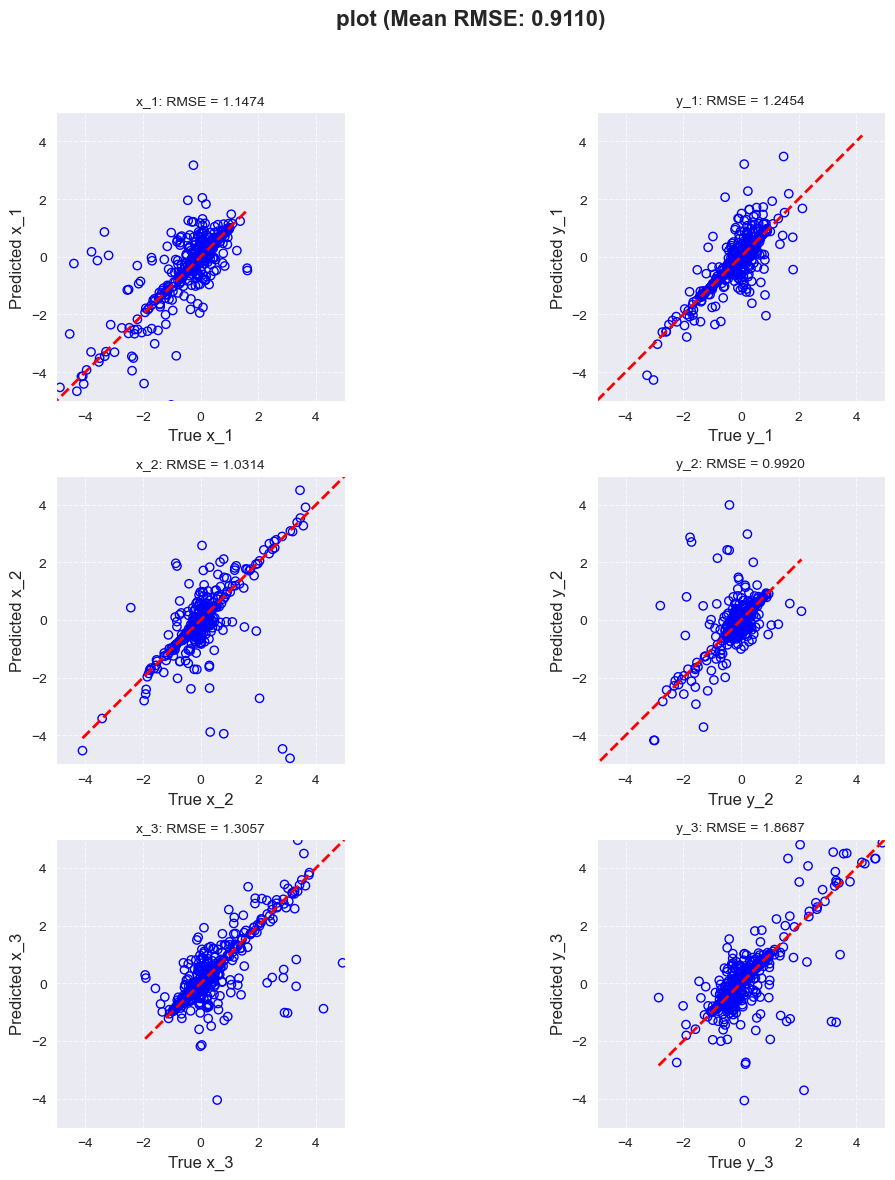

In [51]:
plot_y_yhat(y_pred_val_4, y_val)

# Comparison

In [100]:
results_baseline

{'train_rmse': 1.1983849032833054,
 'val_rmse': 1.210552262305354,
 'test_rmse': 1.3307060307832084}

In [101]:
results_2

{'train_rmse': 1.1518874143633868,
 'val_rmse': 1.1882602617299183,
 'test_rmse': 1.3150799834621378}

In [102]:
results_32

{'train_rmse': 1.1518874143633868,
 'val_rmse': 1.1882602617299183,
 'test_rmse': 1.3150799834621378}

In [104]:
results_4

{'train_rmse': 0.8155519179377385,
 'val_rmse': 0.9270674477017001,
 'test_rmse': 1.0932316248388734}